# Case 3: Weekly Sales Forecasting

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Necessary Libraries

In [3]:
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from pylab import rcParams
import itertools
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

from fbprophet import Prophet

## Reading Data

As the first step, we need to read the data from the CSV file and then convert the `InvoiceDate` column into datetime. 

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/online_retail_II.csv')

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Data Wrangling and Data Aggregation

Next, we can start with data wrangling to build our features for our time series model later on. First, we aggregate the sales  weekly.

In [5]:
df.index = pd.to_datetime(df['InvoiceDate'])
df = df.resample('W').Quantity.sum()
df = df.fillna(0)

In [6]:
df.head()

InvoiceDate
2009-12-06    136455
2009-12-13    111826
2009-12-20    133295
2009-12-27     38512
2010-01-03         0
Freq: W-SUN, Name: Quantity, dtype: int64

In [7]:
data = df

Now we can plot the weekly sales based on the new dataframe that we have created before.

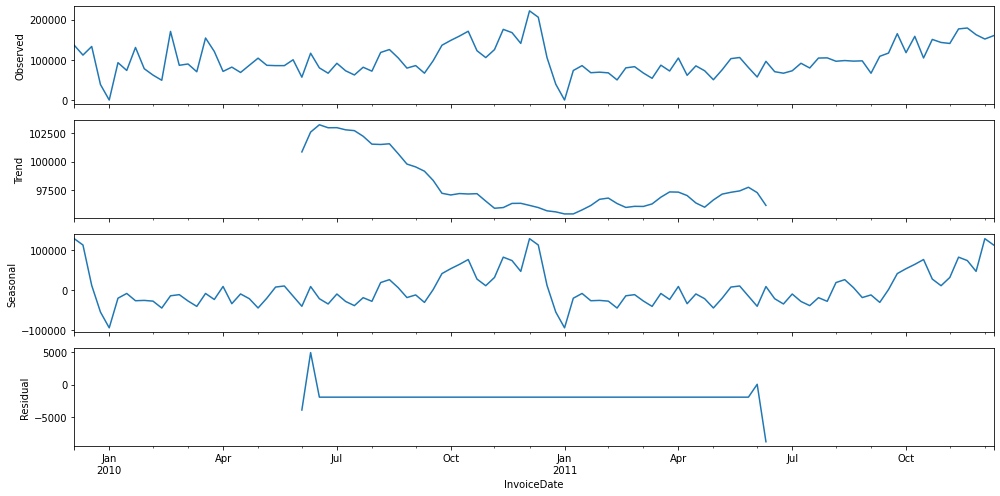

In [8]:
rcParams['figure.figsize'] = 14, 7
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

As we can see from the plot above, the sales data is not stationary and there is seasonality that appears. This means that the sales is relatively low in the beginning of the year, i.e January until around August, and then the sales spike up around September to December. This seasonality has been repeated for the last 2 years of the data, so we need to make sure that we use the right time series forecasting algorithm to tackle this problem.

## Building Time Series Forecasting Model with SARIMA

As our data has seasonality in it and we can consider our problem as a univariate time series, then it will be appropriate to use SARIMA. SARIMA stands for Seasonal Autoregressive Integrated Moving Average, which works similarly with ARIMA. However, ARIMA wouldn't be suitable for this problem since ARIMA only takes trend into account, but not seasonality. Meanwhile, SARIMA is a forecasting method which takes both trend and seasonality into account.

The notation of SARIMA then can be written as:
```
SARIMA(p,d,q)(P,D,Q)m
```

where:
1. `p` is the trend autoregressive order.
2. `d` is the trend difference order.
3. `q` is the trend moving average order.
4. `P` is the seasonal autoregressive order.
5. `D` is the seasonal difference order.
6. `Q` is the seasonal moving average order
7. `m` is the time step for single seasonal period.

Below is the example of how SARIMA notaion would look like in action:

```
SARIMA(1,1,0)(1,1,0)12
```

Now we know that there are a lot of parameters to consider when we want to build a SARIMA model. More often than not, we don't know the optimum parameters to build the best performing SARIMA model. Hence, we are going to implement a grid search algorithm and observe the Akaike Information Criterion (AIC) of each generated model.

In [9]:
p = d = q = range(0, 2)
trend_pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

for param_trend in trend_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param_trend,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param_trend, param_seasonal, results.aic))
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:2732.8863592830476
ARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:2583.7174017113234
ARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:2456.081197284674
ARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:2336.8880179633193
ARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:2486.9528999446493
ARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:2438.3522263215755
ARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:2359.8949466310264
ARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:2338.1276541156376
ARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC:2647.100830261452
ARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC:2528.530371789954
ARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC:2413.098946874451
ARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC:2290.2650860151084
ARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC:2568.0987216290664
ARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC:2516.502665506564
ARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC:2338.839056748296
ARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC:2291.9857823335196
ARIMA(0, 1, 0)x(0, 0, 0, 4) - AIC:2483.077418239217
ARIMA(0, 1, 0)x(0, 0, 1, 4) - AIC:2378.72154526208
ARIMA(0, 1, 0)x(0, 1, 0, 4) - AIC:2439.2168832307293
AR

From the grid search operation above, we can see that the model with minimum AIC can be generated when the (p,d,q)(P,D,Q,m) parameters is (1,1,1)(0,1,1,4). Now let's build SARIMA model with this set of parameters.

In [10]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

Before we use the SARIMA model for prediction, it's always best to find out the property of the model, such as the residual error and the quantiles. From the plot below, although it's not perfect, but we can say that the residual error of the model is more or less normally distributed, hence we can safely use this SARIMA model.

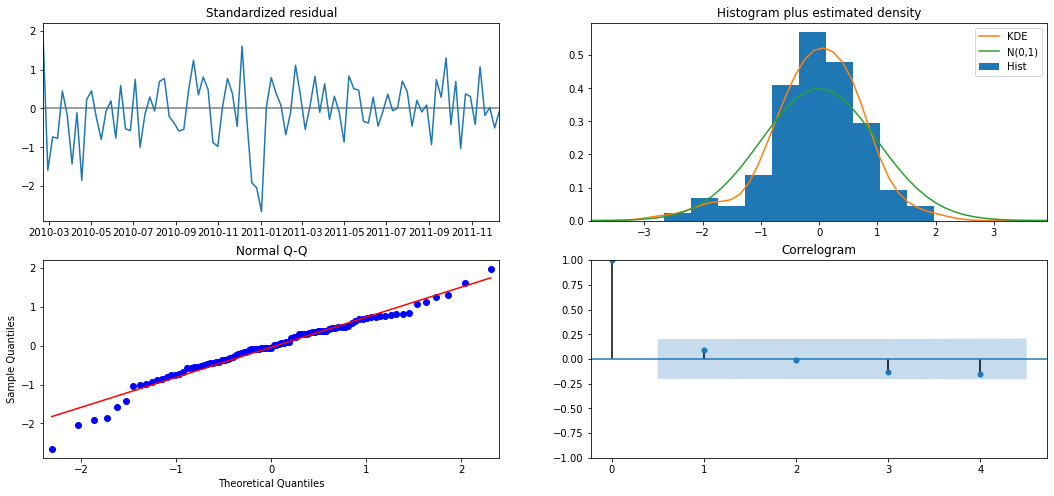

In [11]:
results.plot_diagnostics(lags=4,figsize=(18, 8))
plt.show()

Now we can predict the sales in our data. In the following code and plot, I am going to use the SARIMA model to predict the weekly sales from 3rd of July 2011 onwards.

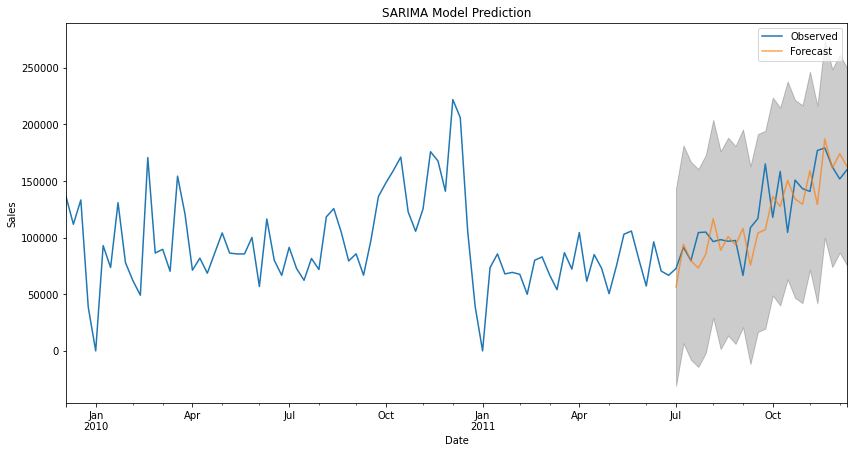

In [12]:
pred = results.get_prediction(start=pd.to_datetime('2011-07-03'), dynamic=False)
pred_ci = pred.conf_int()
ax = data['2009':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('SARIMA Model Prediction')
plt.legend()
plt.show()

As we can see above, our SARIMA model can recognize the trend and the seasonality of the weekly sales, although I believe the performance of this SARIMA model can be greatly improved if we have more data, for example data from the last 5 years instead of just 1.5 years. The more the data we have, the better the SARIMA model to recognize the seasonality.

In [13]:
y_forecasted = pred.predicted_mean
y_truth = data['2009-12-06':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 25476.27


## Building Time Series Forecasting Model with Prophet

Aside of using SARIMA, I am also going to use an open-source library specific for time series forecasting called Prophet. Prophet is a library released by Facebook and I find that this library is a great tool to forecast univariate time series problem like what we currently have right now, especially if the time series has a trend and seasonality.

First, let's prepare the necessary data.

In [14]:
df = df.reset_index()
df = df.rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})

In [15]:
df.head()

,ds,y
0,2009-12-06,136455
1,2009-12-13,111826
2,2009-12-20,133295
3,2009-12-27,38512
4,2010-01-03,0


Now we can start building our model with Prophet. All we need to do is calling Prophet object, and specify the confidence interval of the forecast. 

In [16]:
sales_model = Prophet(interval_width=0.95)
sales_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Next, we can start doing the sales forecasting with `predict()` method. As you can see from the following code, the frequency is set to 'W', which means weekly, and the periods is set to 12, which means I want the model to forecast the sales in the next 3 months.

In [17]:
sales_forecast = sales_model.make_future_dataframe(periods=12, freq='W')
sales_forecast = sales_model.predict(sales_forecast)

<Figure size 1440x720 with 0 Axes>

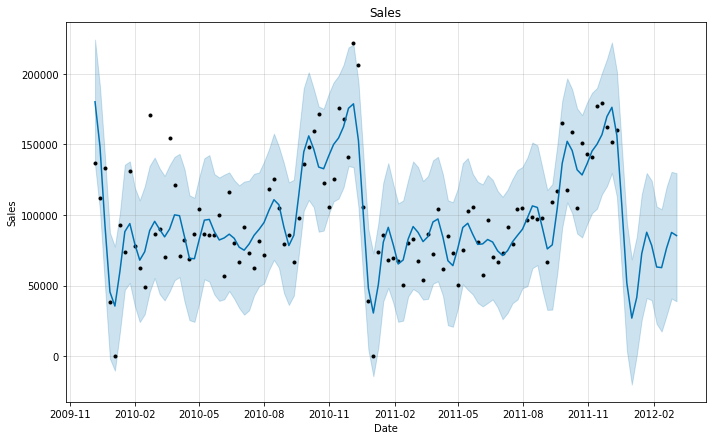

In [18]:
plt.figure(figsize=(20, 10))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales');

We can see that our model can capture the seasonality of our data perfectly. Like in the transition between December and January, the model predicts the sales downward trend with very narrow confidence interval, which means that the model is very sure that the sales will drop in January.

Next, let's find out the overall trend of the sales in general. 

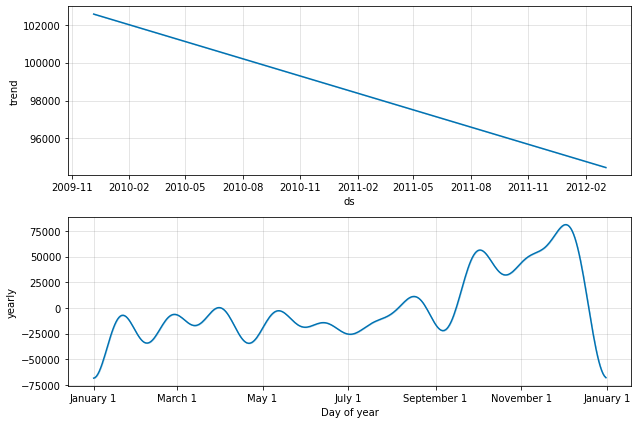

In [19]:
sales_model.plot_components(sales_forecast);

From the plot above, we can see that overall, the amount of sales is showing downward trend within each month. Hence, a new business strategy is needed in order to counter this trend. Meanwhile, we can also see that the amount of sales is very high only in specific months, between October and December.

## Building Time Series Forecasting Model with LSTM

The third approach that can be implemented to forecast weekly aggregated sales is by using deep learning model. In this section, I would like to utilize LSTM to forecast the weekly sales.

Before we build the model, we need to do data wrangling and feature engineering first.

In [20]:
df_diff = df.copy().reset_index()
df_diff = df_diff.rename(columns={'ds':'InvoiceDate', 'y':'Quantity'})

In [21]:
df_diff.head()

,index,InvoiceDate,Quantity
0,0,2009-12-06,136455
1,1,2009-12-13,111826
2,2,2009-12-20,133295
3,3,2009-12-27,38512
4,4,2010-01-03,0


### Introducing Difference to Remove Seasonality

From the previous section, we know that our time series data has seasonality in it. In order for our LSTM to work, we need to transform the time series data such that it becomes more stationary. One of the method that we can use to introduce stationarity is by applying differencing method, which is the subtraction between sales from one month to previous month.

In [22]:
df_diff['PrevSales'] = df_diff['Quantity'].shift(1)
df_diff = df_diff.dropna()
df_diff['Diff'] = (df_diff['Quantity'] - df_diff['PrevSales'])
df_diff.head()

,index,InvoiceDate,Quantity,PrevSales,Diff
1,1,2009-12-13,111826,136455.0,-24629.0
2,2,2009-12-20,133295,111826.0,21469.0
3,3,2009-12-27,38512,133295.0,-94783.0
4,4,2010-01-03,0,38512.0,-38512.0
5,5,2010-01-10,92971,0.0,92971.0


### Introducing Lags 

Aside from differencing method, another thing that we can do to remove seasonality is by applying lags in the time series data. This can be done by shifting the time series data and then compare the shifted time series data with the original one.  In our case, we will do 4 different lags.

In [23]:

df_features= df_diff.drop(['PrevSales'],axis=1)

for i in range(1,5):

    field_name = 'lag_' + str(i)
    df_features[field_name] = df_features['Diff'].shift(i)
    
df_features = df_features.dropna().reset_index(drop=True)

In [24]:
df_features.head()

,index,InvoiceDate,Quantity,Diff,lag_1,lag_2,lag_3,lag_4
0,5,2010-01-10,92971,92971.0,-38512.0,-94783.0,21469.0,-24629.0
1,6,2010-01-17,73633,-19338.0,92971.0,-38512.0,-94783.0,21469.0
2,7,2010-01-24,130851,57218.0,-19338.0,92971.0,-38512.0,-94783.0
3,8,2010-01-31,77908,-52943.0,57218.0,-19338.0,92971.0,-38512.0
4,9,2010-02-07,62061,-15847.0,-52943.0,57218.0,-19338.0,92971.0


With the lag features as shown above, we basically turned our time series data into supervised data. Next, we can proceed to split our supervised data into training and test set. For this case, I am going to use the last 5 months as test data. But before that, we need to normalize the value of our data.

In [25]:
df_model = df_features.drop(['Quantity','InvoiceDate'],axis=1)
train_set, test_set = df_model[0:-24].values, df_model[-24:].values

In [26]:
# Normalize training and test data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [27]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Build LSTM Model

Now that we have our supervised data with differencing method and lags, we can proceed to build our LSTM model. Since our input data is not that complex, then simple LSTM model would be good enough. The LSTM model will be trained with Adam optimizer and we can use MSE as the metrics

In [28]:
model = Sequential()
model.add(LSTM(16, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 16)                   1408      
_________________________________________________________________
dense (Dense)                (1, 1)                    17        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1, shuffle=False)

Epoch 1/300
77/77 [==============================] - 1s 1ms/step - loss: 0.3885
Epoch 2/300
77/77 [==============================] - 0s 1ms/step - loss: 0.3715
Epoch 3/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3710
Epoch 4/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 5/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3618
Epoch 6/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3583
Epoch 7/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3553
Epoch 8/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3526
Epoch 9/300
77/77 [==============================] - 0s 1ms/step - loss: 0.3502
Epoch 10/300
77/77 [==============================] - 0s 2ms/step - loss: 0.3479
Epoch 11/300
77/77 [==============================] - 0s 1ms/step - loss: 0.3456
Epoch 12/300
77/77 [==============================] - 0s 1ms/step - loss: 0.3433
Epoch 13/300
77/77 [=================

### Generate and Preprocess Prediction

After model training, we can use the model to predict the test data. After that, we need preprocess the prediction because we have normalized the data before. Hence, we basically need to inverse the scale back to the original so that we can compare the prediction result with the original time series data.

In [30]:
y_pred = model.predict(X_test,batch_size=1)

In [31]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
pred_test_set = []

for index in range(0,len(y_pred)):
   
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

Next, we can generate a new dataframe which consists of the original time series data and also the prediction time series data.

In [32]:
result_list = []
sales_dates = list(df_diff[-25:].InvoiceDate)
act_sales = list(df_diff[-25:].Quantity)

for index in range(0,len(pred_test_set_inverted)):

    result_dict = {}
    result_dict['PredValue'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['InvoiceDate'] = sales_dates[index+1]
    result_list.append(result_dict)

df_result = pd.DataFrame(result_list)

In [33]:
df_ori = df.copy().reset_index()
df_ori = df_ori.rename(columns={'ds':'InvoiceDate', 'y':'Quantity'})
df_sales_pred = pd.merge(df_ori,df_result,on='InvoiceDate',how='left').drop(columns=['index'])
df_sales_pred.set_index('InvoiceDate', inplace=True)

Finally, we can visualize the forecasting of our LSTM model as follows:

In [34]:
df_sales_pred.tail()

,Quantity,PredValue
InvoiceDate,,
2011-11-13,176997,140890.0
2011-11-20,179216,177102.0
2011-11-27,162568,179319.0
2011-12-04,151807,162672.0
2011-12-11,160167,151909.0


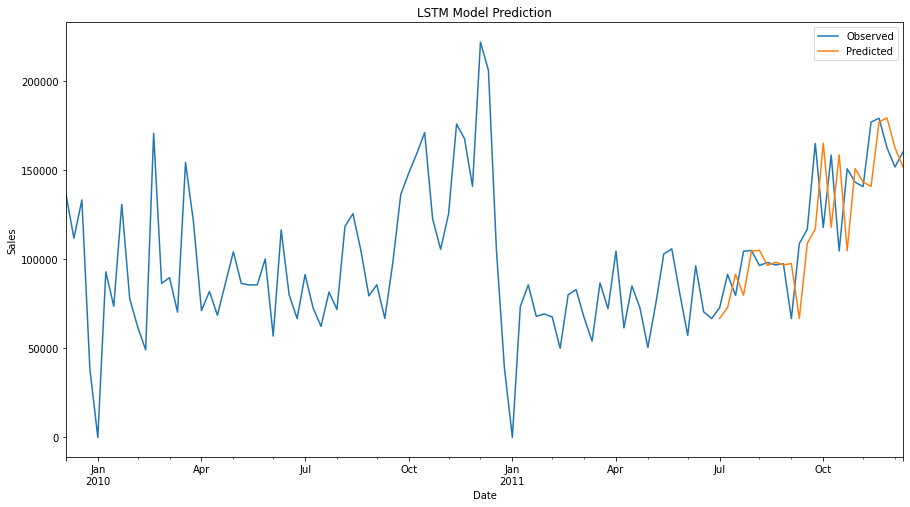

In [35]:
fig = df_sales_pred.plot(figsize=(15,8), title = "LSTM Model Prediction")
fig.set_xlabel("Date")
fig.set_ylabel("Sales")
fig.legend(["Observed", "Predicted"]);

As we can see above,  the LSTM model is able to capture the trend and the seasonality of the weekly sales time series data with a good performance.